Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best Score: 0.7842222222222222
Best Params: {'hgb__l2_regularization': 1, 'hgb__learning_rate': 0.05, 'hgb__max_bins': 255, 'hgb__max_iter': 200, 'hgb__max_leaf_nodes': 31, 'hgb__min_samples_leaf': 10}
Test Accuracy: 0.804
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       254
           1       0.79      0.81      0.80       246

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



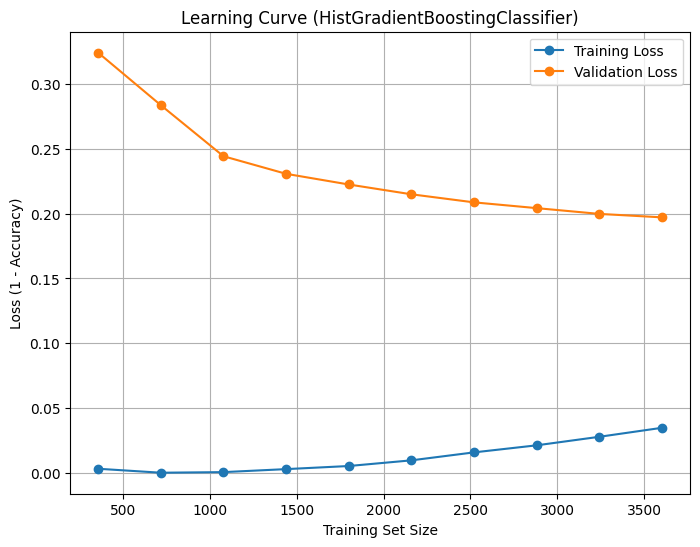

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import learning_curve, GridSearchCV

# =======================
# Data Preparation
# =======================

data_df = pd.read_csv('clean_data.csv')
data_df = data_df.sample(n=5000, random_state=1).reset_index(drop=True)

data_df['Rating'] = pd.to_numeric(data_df['Rating'], errors='coerce')
data_df = data_df.dropna(subset=['Rating'])
data_df['Rating'] = data_df['Rating'].astype(int)

train_df = data_df.iloc[:4500].reset_index(drop=True)
test_df = data_df.iloc[4500:].reset_index(drop=True)

for col in ['Title', 'Review']:
    train_df[col] = train_df[col].fillna('').astype(str)
    test_df[col] = test_df[col].fillna('').astype(str)

X_train = train_df[['Title', 'Review']]
y_train = train_df['Rating']
X_test = test_df[['Title', 'Review']]
y_test = test_df['Rating']

# =======================
# Pipeline Construction
# =======================

get_title = FunctionTransformer(lambda x: x['Title'], validate=False)
get_review = FunctionTransformer(lambda x: x['Review'], validate=False)

title_pipeline = Pipeline([
    ('selector', get_title),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])
review_pipeline = Pipeline([
    ('selector', get_review),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])

combined_features = FeatureUnion(
    transformer_list=[
        ('title', title_pipeline),
        ('review', review_pipeline)
    ],
    transformer_weights={'title': 0.2, 'review': 0.8}
)

to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Create the pipeline with HistGradientBoostingClassifier
pipeline = Pipeline([
    ('features', combined_features),
    ('to_dense', to_dense),
    ('hgb', HistGradientBoostingClassifier(random_state=1))
])

# =======================
# Reduced Parameter Grid
# =======================
# Splitting the grid into two parts, but with fewer total parameter values.

param_grid = [
    {
        'hgb__learning_rate': [0.05, 0.1],
        'hgb__max_iter': [100, 200],
        'hgb__min_samples_leaf': [10],
        'hgb__max_leaf_nodes': [31],
        'hgb__max_bins': [255],
    },
    {
        'hgb__learning_rate': [0.05, 0.1],
        'hgb__max_iter': [100, 200],
        'hgb__min_samples_leaf': [10],
        'hgb__l2_regularization': [0, 1],
        'hgb__max_leaf_nodes': [31],
        'hgb__max_bins': [255],
    }
]

# =======================
# Grid Search
# =======================

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,       # fewer folds (2 instead of 3) to speed up the process
    verbose=1,
    n_jobs=-1   # use all available cores in parallel
)

grid_search.fit(X_train, y_train)

print("Best Score:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

# =======================
# Final Model Evaluation
# =======================

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# =======================
# Learning Curve
# =======================

#train_sizes, train_scores, val_scores = learning_curve(
#    best_model, X_train, y_train,
#    n_jobs=-1,
#    train_sizes=np.linspace(0.1, 1.0, 10),
#    scoring='accuracy'
#)

#train_scores_mean = np.mean(train_scores, axis=1)
#val_scores_mean = np.mean(val_scores, axis=1)

#train_loss = 1 - train_scores_mean
#val_loss = 1 - val_scores_mean

#plt.figure(figsize=(8, 6))
#plt.plot(train_sizes, train_loss, 'o-', label="Training Loss")
#plt.plot(train_sizes, val_loss, 'o-', label="Validation Loss")
#plt.xlabel("Training Set Size")
#plt.ylabel("Loss (1 - Accuracy)")
#plt.title("Learning Curve (HistGradientBoostingClassifier)")
#plt.legend()
#plt.grid(True)
#plt.show()
